# Sentiment Analysis of Amazon Customer Reviews for iPhone 15, Samsung S24 & Pixel 7

## Introduction
In today's highly competitive smartphone market, understanding customer sentiment is essential for manufacturers and sellers aiming to improve user experience and brand loyalty. This project focuses on analyzing customer reviews collected from Amazon for three flagship smartphones: **Apple iPhone 15, Samsung Galaxy S24, and Google Pixel 7** .

Using Natural Language Processing (NLP) techniques, we performed a **comparative sentiment analysis** to evaluate how customers perceive each device. The reviews were first scraped directly from Amazon, preprocessed, and then analyzed using the RoBERTa transformer model, which classifies sentiments into positive, neutral, and negative categories.

Beyond sentiment scoring, the project also identifies frequently occurring complaints in negative reviews for each phone, offering insight into common issues such as battery life, heating, and customer service. The results are visualized through charts and word clouds, allowing for an intuitive understanding of customer feedback trends.

This analysis not only highlights the overall sentiment toward each smartphone but also provides valuable feedback signals that can inform marketing strategies, product development, and customer support improvements.

## Import Libraries

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
from tqdm.notebook import tqdm
from wordcloud import WordCloud

## Reading Amazon Review Data

In [3]:
#Read data
iphone_df = pd.read_csv("iphone15_amazon_reviews.csv")
s24_df = pd.read_csv("S24_amazon_reviews.csv")
pixel_df = pd.read_csv("pixel_amazon_reviews.csv")

## Cleaning data

In [5]:
def clean_review_data(df):
    """
    Cleans a review DataFrame by:
    - Removing rating text from 'Title' column (e.g., '5.0 out of 5 stars')
    - Extracting 'Country' from 'Date' column
    - Converting 'Date' column to datetime format

    Parameters:
    - df (pd.DataFrame): Input DataFrame with columns ['Title', 'Rating', 'Review', 'Date']

    Returns:
    - pd.DataFrame: Cleaned DataFrame with updated 'Title', 'Date', and new 'Country' column
    """

    # Clean the Title column
    df['Title'] = df['Title'].str.replace(r'^\d+\.0 out of 5 stars', '', regex=True).str.strip()

    # Extract country from the Date column
    df['Country'] = df['Date'].str.extract(r'Reviewed in ([a-zA-Z\s]+) on')

    # Extract and convert the actual date part
    df['Date'] = df['Date'].str.extract(r'on (.+)')
    df['Date'] = pd.to_datetime(df['Date'], format='%d %B %Y', errors='coerce')

    return df


In [7]:
#Apply function to data
iphone_df = clean_review_data(iphone_df)
s24_df = clean_review_data(s24_df)
pixel_df = clean_review_data(pixel_df)

In [9]:
#First 5 rows of data
iphone_df.head()

,Title,Rating,Review,Date,Country
0,iPhone XR to iPhone 15,5.0,Just made the transition and here’s my POV on ...,2023-10-07,India
1,Stunning Pink – A Perfect Blend of Beauty & Pe...,5.0,I recently purchased the iPhone 15 in Pink fro...,2025-03-21,India
2,iPhone 15 A solid upgrade and value for money,5.0,DesignOne of the most noticeable changes to th...,2023-10-06,India
3,"⭐️⭐️⭐️⭐️⭐️ Sleek, Fast & Reliable – A Solid Up...",4.0,The iPhone 15 is a noticeable step up from pre...,2025-05-26,India
4,Product good delevery bad,5.0,Product was good but the delivery boy from blu...,2025-06-17,India


### Cleaning Data for Sentiment Analysis

In [11]:
import re

def clean_review_text(text):
    """
    Cleans review text for transformer-based sentiment models like RoBERTa.

    Removes:
    - URLs
    - Mentions (@username)
    - Non-letter characters (except basic punctuation)
    - Extra whitespace
    - Converts to lowercase
    """
    text = str(text)
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove @mentions
    text = re.sub(r"[^a-zA-Z0-9\s.,!?']", " ", text)  # Remove emojis & symbols but keep punctuation
    text = re.sub(r"\s+", " ", text).strip()  # Normalize whitespace
    text = text.lower()  # Convert to lowercase
    return text


In [13]:
# Apply cleaning to the Review column
iphone_df['Cleaned_Review'] = iphone_df['Review'].apply(clean_review_text)
s24_df['Cleaned_Review'] = s24_df['Review'].apply(clean_review_text)
pixel_df['Cleaned_Review'] = pixel_df['Review'].apply(clean_review_text)


## Review Star Distribution by Device

In [15]:


def plot_rating_distributions_side_by_side(df1, df2, df3, names):
    """
    Plots rating distributions of three datasets side by side in one figure.

    Parameters:
    - df1, df2, df3: Pandas DataFrames with 'Rating' column
    - names: List of three device names [name1, name2, name3]
    """

    # Create a row of 3 subplots with shared y-axis
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    
    # Iterate through each dataframe, name, and corresponding axis
    for i, (df, name, ax) in enumerate(zip([df1, df2, df3], names, axes)):

        ## Get rating counts sorted by star value (1 to 5)
        rating_counts = df["Rating"].value_counts().sort_index()
        colors = []  # Color list for bars

        # Assign bar colors based on star rating
        for rating in rating_counts.index:
            if rating in [1, 2]:
                colors.append('red')   # Negative: Red
            elif rating == 3:
                colors.append('gray')  # Neutral: Gray
            else:
                colors.append('green') # Positive: Green

        # Plot the bar chart for the current dataset
        rating_counts.plot(kind='bar',
                           color=colors,
                           ax=ax,
                           title=f"{name}",  # Device name as subplot title
                           rot=0)            # Rotate x-axis labels
        ax.set_xlabel("Stars")               # Label x-axis
        if i == 0:
            ax.set_ylabel("Count")           # Label y-axis only for first plot
    # Set the overall figure title
    fig.suptitle("⭐ Review Star Distribution by Device", fontsize=16)
    
    plt.tight_layout()             # Avoid label overlap
    plt.subplots_adjust(top=0.85)  # space for the suptitle
    plt.show()                     # Display the plot


C:\Users\Netcom\AppData\Local\Temp\ipykernel_3084\2901812748.py:33: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Netcom\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 11088 (\N{WHITE MEDIUM STAR}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


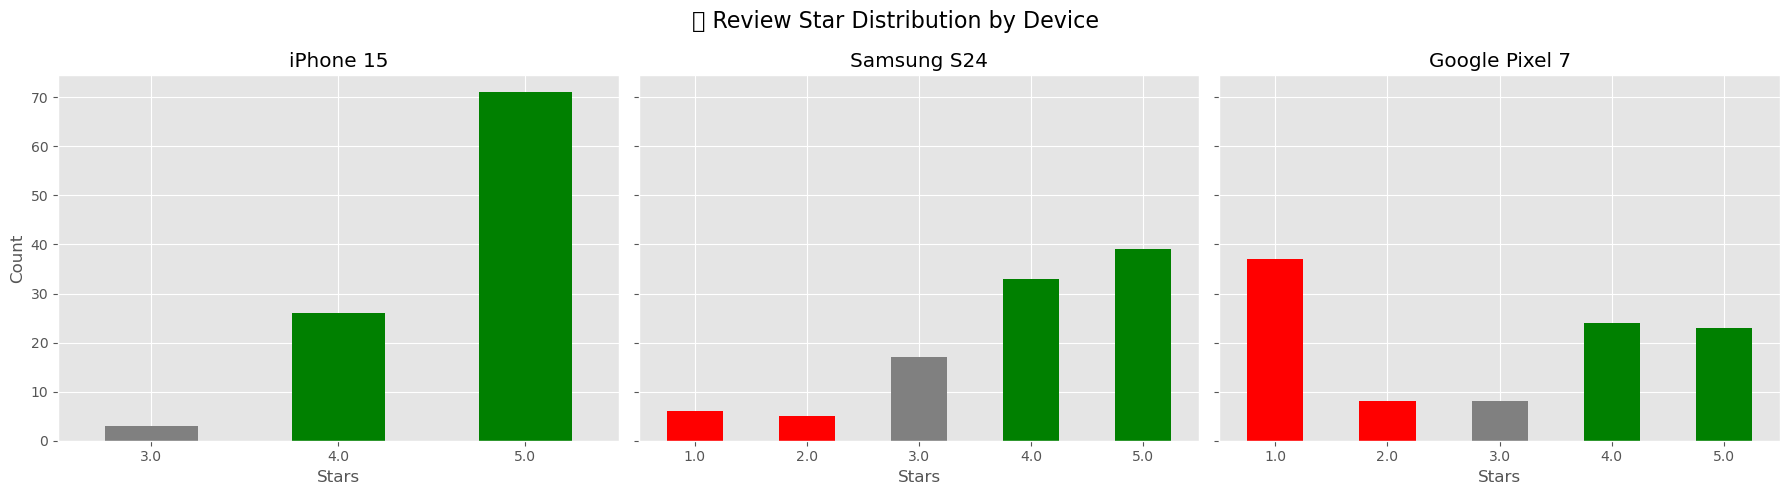

In [17]:
# Define device names in the same order as the DataFrames
device_names = ["iPhone 15", "Samsung S24", "Google Pixel 7"]

# Call the function to plot rating distributions for all three devices side by side
plot_rating_distributions_side_by_side(iphone_df, s24_df, pixel_df, device_names)


### Customer Rating Distribution – Bar Chart Analysis

The chart above presents a side-by-side comparison of star ratings from Amazon customer reviews for iPhone 15, Samsung S24, and Google Pixel 7.

- **iPhone 15** shows overwhelmingly positive feedback, with the majority of users awarding 5-star ratings, and very few neutral or negative reviews. This indicates strong customer satisfaction and product performance.

- **Samsung S24** receives a more balanced distribution, with significant 4-star and 5-star ratings, but also a noticeable percentage of 1 to 3-star ratings, suggesting mixed experiences—particularly around performance or expectations.

- **Google Pixel 7** has the highest proportion of low ratings, with a large number of 1-star reviews. While some users still rate it positively, this pattern highlights dissatisfaction possibly related to service, reliability, or delivery issues.



In [19]:
def plot_rating_pie_charts(df1, df2, df3, names):
    """
    Plots pie charts of rating distributions for three datasets side by side.

    Parameters:
    - df1, df2, df3: Pandas DataFrames with 'Rating' column
    - names: List of device names (length 3)
    """

    # Create a row of 3 subplots (1 row, 3 columns) for the pie charts
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    
    # Iterate through each DataFrame, name, and axis
    for i, (df, name, ax) in enumerate(zip([df1, df2, df3], names, axes)):

        # Count how many reviews each rating (1–5 stars) received
        rating_counts = df['Rating'].value_counts().sort_index()

        # Use the rating numbers (1–5) as labels
        labels = rating_counts.index
        
        # Plot pie chart for current device
        ax.pie(rating_counts, labels=labels, autopct='%1.1f%%', startangle=90)  # Show percentage with 1 decimal,Start angle for consistent layout

        # Set device name as subplot title
        ax.set_title(f"{name}")
        
    # Set the overall title for the figure
    fig.suptitle("📊 Rating Distribution - Pie Charts", fontsize=16) 
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.subplots_adjust(top=0.85) # Add space for the main title
    plt.show()         # Display the final plot

C:\Users\Netcom\AppData\Local\Temp\ipykernel_3084\418611697.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Netcom\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


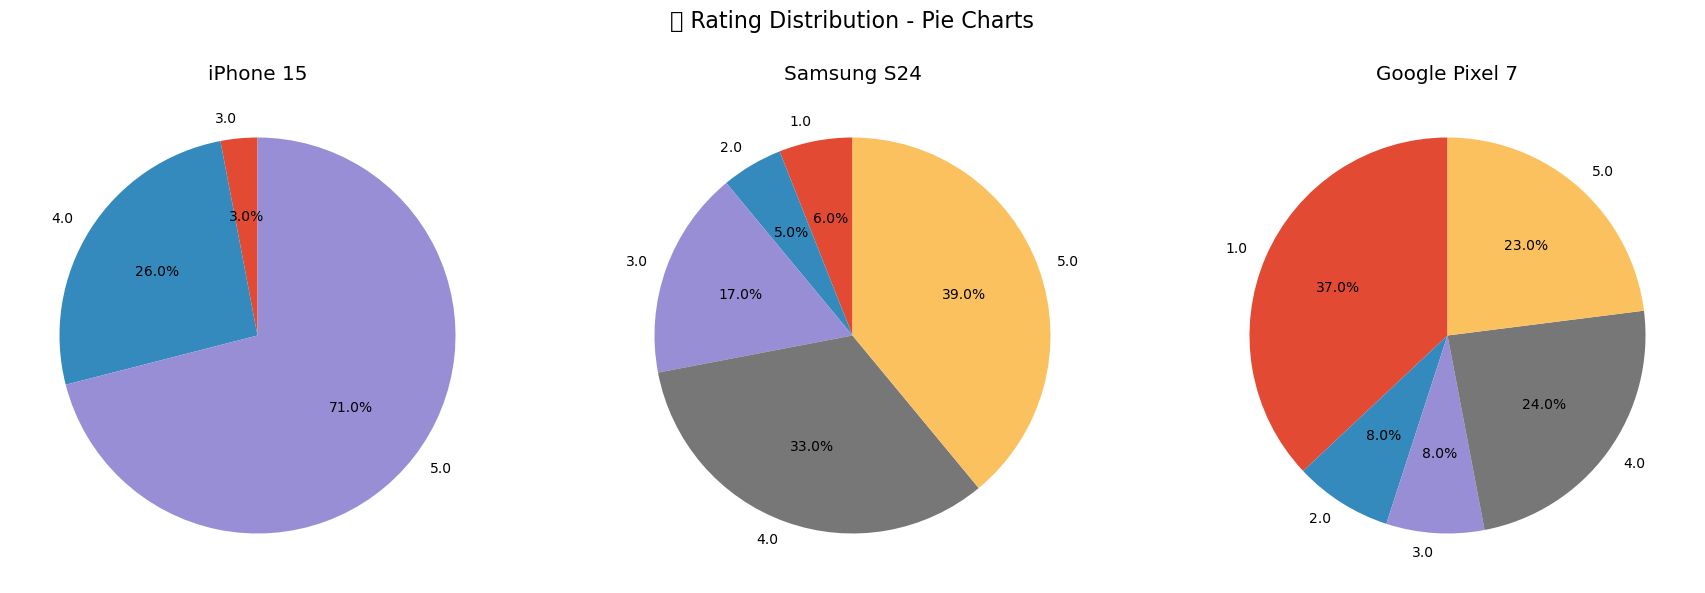

In [21]:
# Device names
device_names = ["iPhone 15", "Samsung S24", "Google Pixel 7"]

# Call the function
plot_rating_pie_charts(iphone_df, s24_df, pixel_df, device_names)


### Customer Rating Distribution – Comparative Insights
The pie charts above illustrate the distribution of customer star ratings for the iPhone 15, Samsung S24, and Google Pixel 7 based on Amazon reviews.

iPhone 15 shows the highest customer satisfaction, with a dominant 71% of reviews rated 5 stars and only 3% rated 3 stars or below, indicating a strong positive reception from users.

Samsung S24 has a more varied distribution. While 39% of users gave it 5 stars, a significant portion (33% rated 4 stars and 17% rated 3 stars) suggests a more mixed experience, with both appreciation and room for improvement.

Google Pixel 7 reflects the most negative customer perception, with 37% of users giving just 1 star, and only 23% giving 5 stars. This indicates a substantial number of dissatisfied customers, likely tied to the service and support issues seen in sentiment analysis.

In [23]:
#Add new column id
def add_id_column(df):
    """
    Adds an 'id' column starting from 1 and reorders it to be the first column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame

    Returns:
    - pd.DataFrame: DataFrame with 'id' as the first column
    """
    df = df.copy()  # To avoid modifying the original dataframe
    df["id"] = range(1, len(df) + 1)
    df = df[['id'] + [col for col in df.columns if col != 'id']]
    return df


In [25]:
# Apply to each DataFrame
iphone_df = add_id_column(iphone_df)
s24_df = add_id_column(s24_df)
pixel_df = add_id_column(pixel_df)


## RoBERTa-Based Sentiment Analysis

**RoBERTa** (Robustly Optimized BERT Pretraining Approach) is a state-of-the-art transformer-based language model developed by Facebook AI. It improves upon BERT by training on more data with dynamic masking, making it highly effective for tasks like sentiment analysis. In this project, RoBERTa is used to classify customer reviews into positive, neutral, and negative sentiments with high accuracy.

In [29]:
## Load RoBERTa model and tokenizer for sentiment analysis
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"  # Pretrained RoBERTa model fine-tuned on Twitter sentiment

tokenizer = AutoTokenizer.from_pretrained(MODEL)   # Load tokenizer for text preprocessing
model = AutoModelForSequenceClassification.from_pretrained(MODEL)   # Load sentiment classification model

In [30]:
## Apply RoBERTa Sentiment
def apply_roberta_sentiment(df, tokenizer, model, text_column='Cleaned_Review', id_column='id'):
    """
    Applies RoBERTa sentiment analysis to a DataFrame with a text column.

    Parameters:
    - df (pd.DataFrame): Input DataFrame with review texts and unique 'id' column
    - tokenizer: RoBERTa tokenizer from Hugging Face Transformers
    - model: Pre-trained RoBERTa sentiment model
    - text_column (str): Column name containing review text
    - id_column (str): Column name with unique identifier for merging results

    Returns:
    - pd.DataFrame: Original DataFrame merged with sentiment scores
    """
    res = {}      # Dictionary to store sentiment scores keyed by review ID
    
    # Loop through each row in the DataFrame with progress bar
    for i, row in tqdm(df.iterrows(), total=len(df)):
        try:
            text = row[text_column]    # Extract review text
            myid = row[id_column]      # Extract corresponding ID

            # Tokenize the text and prepare input for RoBERTa
            encoded_text = tokenizer(text, return_tensors="pt", truncation=True, padding=True)

            # Run model inference
            output = model(**encoded_text)

            # Get raw prediction scores and apply softmax
            scores = output[0][0].detach().numpy()
            scores = softmax(scores)
            
            # Store results with ID as key
            res[myid] = {
                "roberta_neg": scores[0],     # Negative sentiment score
                "roberta_neu": scores[1],     # Neutral sentiment score
                "roberta_pos": scores[2]      # Positive sentiment score
            }

        except RuntimeError:
            print(f"⚠️ Runtime error for id {myid}")      # Handle occasional CUDA/memory errors

    # Convert the sentiment results to a DataFrame
    result_df = pd.DataFrame(res).T.reset_index().rename(columns={"index": id_column})

    # Merge sentiment scores back with original DataFrame
    final_df = result_df.merge(df, how="left", on=id_column)

    return final_df    # Return the enriched DataFrame with sentiment columns

In [31]:
#Apply RoBERTa on iphone dataframe
iphone_sentiment_df = apply_roberta_sentiment(iphone_df, tokenizer, model)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


⚠️ Runtime error for id 1


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 13.27it/s]


In [35]:
#Apply RoBERTa on s24 dataframes
24_sentiment_df = apply_roberta_sentiment(s24_df, tokenizer, model)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

⚠️ Runtime error for id 1
⚠️ Runtime error for id 2


 14%|███████████▎                                                                     | 14/100 [00:01<00:05, 14.76it/s]

⚠️ Runtime error for id 13


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.32it/s]


In [39]:
#Apply RoBERTa on pixel dataframe
pixel_sentiment_df = apply_roberta_sentiment(pixel_df, tokenizer, model)

  2%|█▋                                                                                | 2/100 [00:00<00:26,  3.63it/s]

⚠️ Runtime error for id 3
⚠️ Runtime error for id 4


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.74it/s]


In [94]:
#Read the first 5 rows of iphone sentiment dataframe
iphone_sentiment_df.head()

,id,roberta_neg,roberta_neu,roberta_pos,Title,Rating,Review,Date,Country,Cleaned_Review,roberta_sentiment
0,2,0.001506,0.011354,0.987141,Stunning Pink – A Perfect Blend of Beauty & Pe...,5.0,I recently purchased the iPhone 15 in Pink fro...,2025-03-21,India,i recently purchased the iphone 15 in pink fro...,positive
1,3,0.004273,0.155232,0.840495,iPhone 15 A solid upgrade and value for money,5.0,DesignOne of the most noticeable changes to th...,2023-10-06,India,designone of the most noticeable changes to th...,positive
2,4,0.001354,0.014256,0.984390,"⭐️⭐️⭐️⭐️⭐️ Sleek, Fast & Reliable – A Solid Up...",4.0,The iPhone 15 is a noticeable step up from pre...,2025-05-26,India,the iphone 15 is a noticeable step up from pre...,positive
3,5,0.934771,0.060182,0.005047,Product good delevery bad,5.0,Product was good but the delivery boy from blu...,2025-06-17,India,product was good but the delivery boy from blu...,negative
4,6,0.030588,0.130140,0.839272,Good phone,5.0,Switched to IOS from android. Many things are ...,2025-06-07,India,switched to ios from android. many things are ...,positive


In [75]:
#Save the sentiment dataframe in to csv
iphone_sentiment_df.to_csv("iphone_sentiment_analysis.csv", index=False)
s24_sentiment_df.to_csv("s24_sentiment_analysis.csv", index=False)
pixel_sentiment_df.to_csv("pixel_sentiment_analysis.csv", index=False)


## RoBERTa Sentiment vs Rating

In [41]:

def plot_roberta_sentiment_bars(df, device_name):
    """
    Plots barplots of RoBERTa sentiment scores (positive, neutral, negative)
    against Ratings in a side-by-side layout.

    Parameters:
    - df (pd.DataFrame): DataFrame with 'Rating', 'roberta_pos', 'roberta_neu', 'roberta_neg'
    - device_name (str): Name of the device (used as title prefix)
    """
    # Create a figure with 3 horizontal subplots sharing y-axis
    fig, axs = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    # Plot average positive sentiment per rating
    sns.barplot(data=df, x="Rating", y="roberta_pos", ax=axs[0], color="#2ca02c")

    # Plot average neutral sentiment per rating
    sns.barplot(data=df, x="Rating", y="roberta_neu", ax=axs[1], color="#1f77b4")

    # Plot average negative sentiment per rating
    sns.barplot(data=df, x="Rating", y="roberta_neg", ax=axs[2], color="#d62728")
    
    # Set subplot titles with sentiment label and device name
    axs[0].set_title(f"{device_name} - Positive")
    axs[1].set_title(f"{device_name} - Neutral")
    axs[2].set_title(f"{device_name} - Negative")
    
    # Set labels for all subplots
    for ax in axs:
        ax.set_xlabel("Rating")   # X-axis shows rating values (1 to 5)
        ax.set_ylabel("Avg Sentiment Score")   # Y-axis shows sentiment scores (0 to 1)

    # Set a common title for the entire figure
    plt.suptitle(f"RoBERTa Sentiment vs. Rating - {device_name}", fontsize=14)
    plt.tight_layout()           # Automatically adjust layout to avoid overlap
    plt.subplots_adjust(top=0.85) # Provide space for the main title
    plt.show()                    # Display the figure


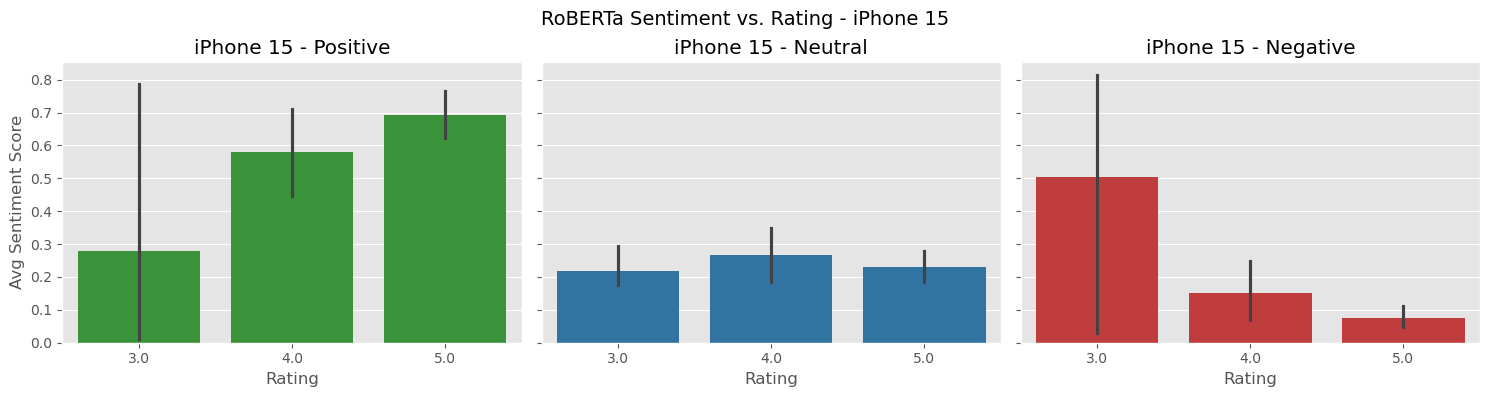

In [43]:
plot_roberta_sentiment_bars(iphone_sentiment_df, "iPhone 15")

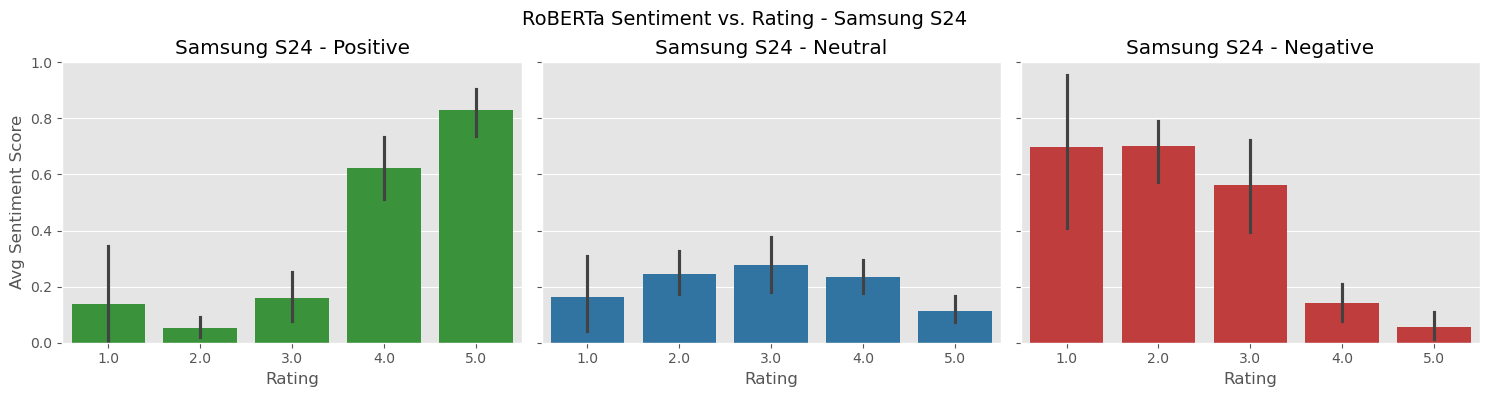

In [45]:
plot_roberta_sentiment_bars(s24_sentiment_df, "Samsung S24")

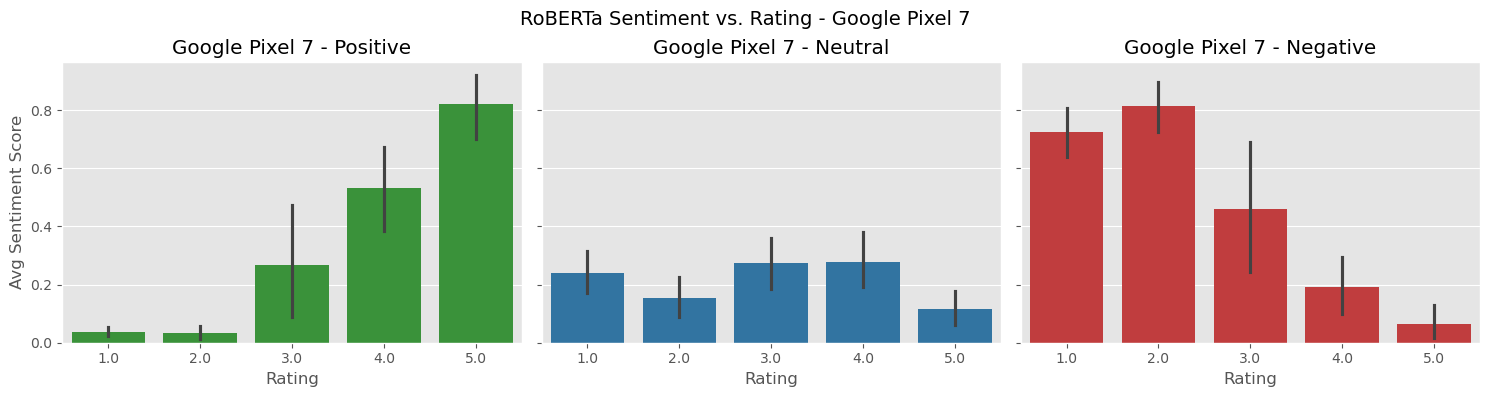

In [47]:
plot_roberta_sentiment_bars(pixel_sentiment_df, "Google Pixel 7")

**The RoBERTa-based sentiment analysis reveals distinct emotional responses across customer ratings for the three devices:**

- iPhone 15 received predominantly positive sentiment scores for higher ratings (4 and 5 stars), while negative sentiment was more associated with mid-level (3-star) reviews. This suggests a generally satisfied customer base with minor dissatisfaction points.

- Samsung S24 also showed a rise in positive sentiment with increasing ratings, though there was a noticeable volume of negative sentiment even at mid ratings. This points to a more mixed perception, where some customers gave higher ratings despite underlying concerns.

- Google Pixel 7 displayed a stark contrast. A large portion of lower ratings (1 and 2 stars) aligned with high negative sentiment, while only 5-star reviews reflected strong positivity. This indicates higher dissatisfaction among Pixel users compared to the other two.

- Overall, these barplots demonstrate that iPhone 15 enjoys the most consistent customer satisfaction, while Google Pixel 7 faces the most polarizing reviews, with Samsung S24 falling in between in sentiment consistency across different rating levels.

### Labelling RoBERTa Sentiment

In [49]:
def add_roberta_sentiment_label(df):
    """
    Adds a column 'roberta_sentiment' based on the highest sentiment score
    from RoBERTa outputs: roberta_pos, roberta_neu, roberta_neg.

    Parameters:
    - df (pd.DataFrame): DataFrame containing sentiment score columns

    Returns:
    - pd.DataFrame: Updated DataFrame with new 'roberta_sentiment' column
    """
    # Define internal function to classify sentiment based on highest score
    def classify_roberta(row):
        scores = {
            "negative": row["roberta_neg"],
            "neutral": row["roberta_neu"],
            "positive": row["roberta_pos"]
        }
        return max(scores, key=scores.get)   # Return the label with highest score

    df = df.copy()             # Create a copy to avoid modifying original DataFrame

    # Apply the classification function row-wise
    df["roberta_sentiment"] = df.apply(classify_roberta, axis=1)
    
    return df       # Return updated DataFrame with sentiment label


In [51]:
# Apply RoBERTa sentiment label classification to iPhone 15 dataset
iphone_sentiment_df = add_roberta_sentiment_label(iphone_sentiment_df)

# Apply RoBERTa sentiment label classification to Samsung S24 dataset
s24_sentiment_df = add_roberta_sentiment_label(s24_sentiment_df)

# Apply RoBERTa sentiment label classification to Google Pixel 7 dataset
pixel_sentiment_df = add_roberta_sentiment_label(pixel_sentiment_df)


In [53]:
iphone_sentiment_df

,id,roberta_neg,roberta_neu,roberta_pos,Title,Rating,Review,Date,Country,Cleaned_Review,roberta_sentiment
0,2,0.001506,0.011354,0.987141,Stunning Pink – A Perfect Blend of Beauty & Pe...,5.0,I recently purchased the iPhone 15 in Pink fro...,2025-03-21,India,i recently purchased the iphone 15 in pink fro...,positive
1,3,0.004273,0.155232,0.840495,iPhone 15 A solid upgrade and value for money,5.0,DesignOne of the most noticeable changes to th...,2023-10-06,India,designone of the most noticeable changes to th...,positive
2,4,0.001354,0.014256,0.984390,"⭐️⭐️⭐️⭐️⭐️ Sleek, Fast & Reliable – A Solid Up...",4.0,The iPhone 15 is a noticeable step up from pre...,2025-05-26,India,the iphone 15 is a noticeable step up from pre...,positive
3,5,0.934771,0.060182,0.005047,Product good delevery bad,5.0,Product was good but the delivery boy from blu...,2025-06-17,India,product was good but the delivery boy from blu...,negative
4,6,0.030588,0.130140,0.839272,Good phone,5.0,Switched to IOS from android. Many things are ...,2025-06-07,India,switched to ios from android. many things are ...,positive
...,...,...,...,...,...,...,...,...,...,...,...
94,96,0.057429,0.279547,0.663025,Good,5.0,Good,2025-05-16,India,good,positive
95,97,0.066370,0.279620,0.654011,Hmm..,5.0,Same as shown but features was not so good as ...,2025-04-21,India,same as shown but features was not so good as ...,positive
96,98,0.239410,0.503805,0.256785,Secy,5.0,Secy,2025-05-15,India,secy,neutral
97,99,0.004935,0.072242,0.922823,Best phone,5.0,Best phone,2025-04-28,India,best phone,positive


## RoBERTa Sentiment Distribution Comparison

In [55]:
def plot_roberta_sentiment_pies(df1, df2, df3, names):
    """
    Plots side-by-side pie charts of RoBERTa sentiment label distributions
    for three datasets.

    Parameters:
    - df1, df2, df3: DataFrames with 'roberta_sentiment' column
    - names: List of device names (e.g., ['iPhone 15', 'Samsung S24', 'Pixel 7'])
    """
    # Create 1 row and 3 columns of subplots (side-by-side)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Iterate over each dataframe, corresponding device name, and subplot axis
    for i, (df, name, ax) in enumerate(zip([df1, df2, df3], names, axes)):

        # Count the sentiment labels (positive, neutral, negative)
        sentiment_counts = df['roberta_sentiment'].value_counts()

        # Get sentiment labels (e.g., positive, neutral, negative)
        labels = sentiment_counts.index

        # Choose pastel color palette for pie chart
        colors = sns.color_palette('pastel')[0:3]

        # Plot the pie chart
        ax.pie(sentiment_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)

        # Set title for each subplot using device name
        ax.set_title(f"{name} Sentiment")

    # Set a main title for the full figure
    fig.suptitle("📊 RoBERTa Sentiment Distribution Comparison", fontsize=16)

    # Adjust layout for better spacing
    plt.tight_layout()

    # Adjust space above for the main title
    plt.subplots_adjust(top=0.85)

    # Display the final plot
    plt.show()


C:\Users\Netcom\AppData\Local\Temp\ipykernel_3084\2105266927.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Netcom\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


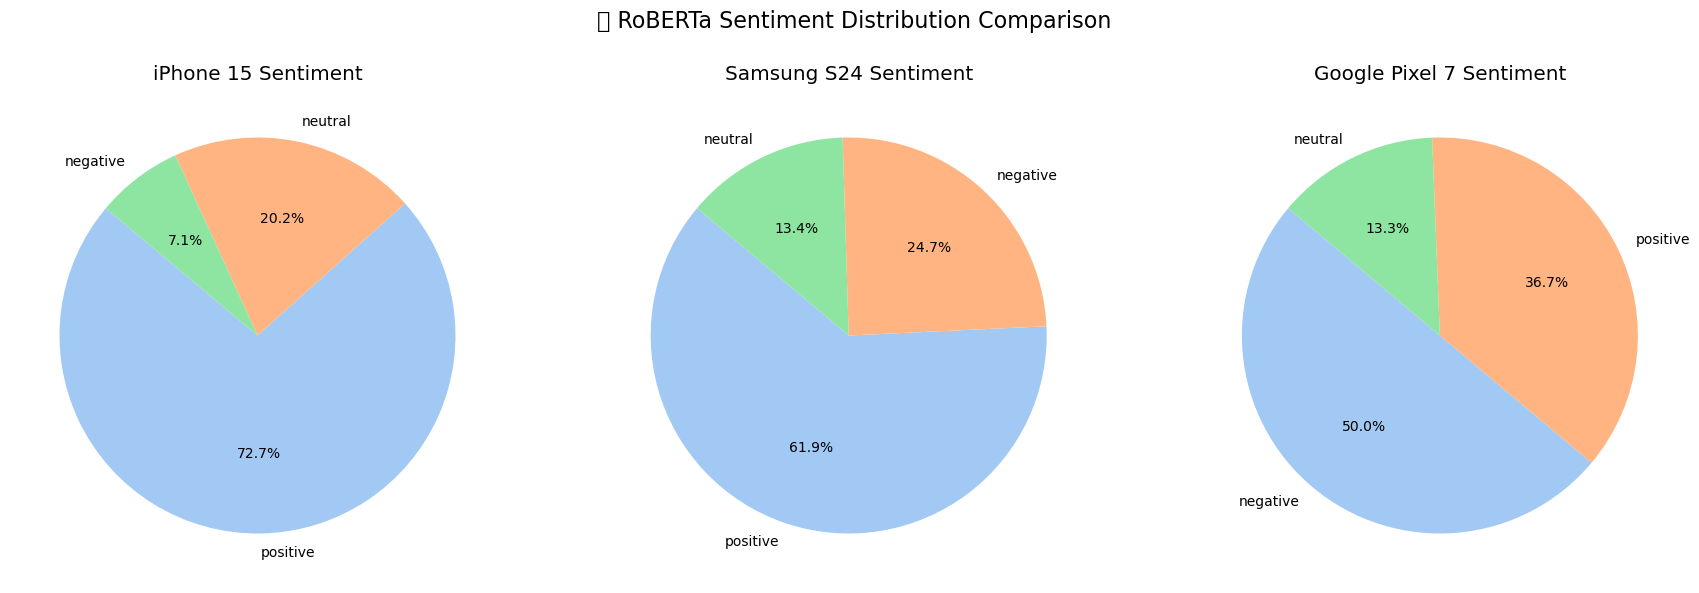

In [57]:
# Define device names to use as labels for the plots
device_names = ["iPhone 15", "Samsung S24", "Google Pixel 7"]

# Call the function to plot RoBERTa sentiment pie charts for each device
# This visualizes how many reviews fall into positive, neutral, or negative categories
plot_roberta_sentiment_pies(iphone_sentiment_df, s24_sentiment_df, pixel_sentiment_df, device_names)

In [7]:
def compare_sentiment_distribution(dfs, names):
    """
    Creates a barplot comparing the proportion of RoBERTa sentiment labels
    (positive, neutral, negative) across multiple devices.

    Parameters:
    - dfs (list): List of DataFrames, each with a 'roberta_sentiment' column
    - names (list): List of device names corresponding to each DataFrame
    """
    sentiment_summary = []  # List to collect sentiment proportions for each device

    
    # Loop through each DataFrame and corresponding device name
    for df, name in zip(dfs, names):

        # Get normalized value counts (i.e., proportion of each sentiment)
        counts = df['roberta_sentiment'].value_counts(normalize=True)

        # Ensure all three sentiment labels are included (even if missing)
        for sentiment in ['positive', 'neutral', 'negative']:
            sentiment_summary.append({
                'Device': name,
                'Sentiment': sentiment,
                'Proportion': counts.get(sentiment, 0)  # Default to 0 if sentiment not present
            })

    # Convert the list of sentiment data to a DataFrame
    summary_df = pd.DataFrame(sentiment_summary)

    # Create a grouped bar plot showing sentiment proportions for each device
    plt.figure(figsize=(10, 6))  # Set figure size
    sns.barplot(data=summary_df, x='Device', y='Proportion', hue='Sentiment', palette='pastel')  # Light color scheme for clarity

    # Set plot title and axis labels
    plt.title("Sentiment Distribution by Device (RoBERTa)")
    plt.ylabel("Proportion of Reviews")

    # Display the plot
    plt.show()

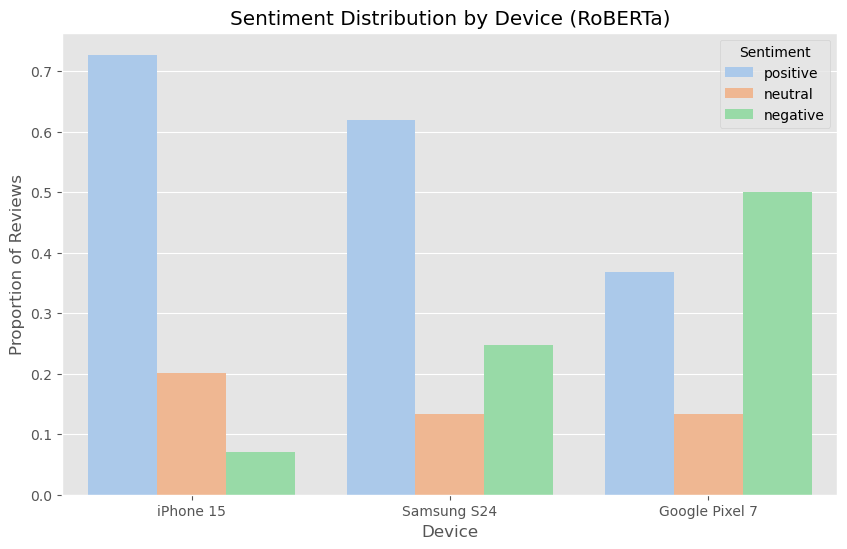

In [61]:
# Call the sentiment comparison function with the sentiment-labeled DataFrames
compare_sentiment_distribution(
    [iphone_sentiment_df, s24_sentiment_df, pixel_sentiment_df],  # List of DataFrames for each phone
    ["iPhone 15", "Samsung S24", "Google Pixel 7"]   # Corresponding device names
)

# This will generate a grouped bar chart showing the proportion of 
# positive, neutral, and negative sentiments for each device
# using the RoBERTa sentiment classification results.

### RoBERTa Sentiment Distribution – Comparative Insights

The RoBERTa-based sentiment analysis reveals a distinct difference in customer experiences across the three smartphone models:

- **iPhone 15** received the highest positive sentiment (72.7%), with only 7.1% negative reviews, indicating strong customer satisfaction.

- **Samsung S24** follows with 61.9% positive sentiment and a comparatively higher 24.7% negative sentiment, suggesting a mixed but largely favorable reception.

- **Google Pixel 7** shows a significant 50% negative sentiment, the highest among all, and only 36.7% positive, reflecting notable dissatisfaction among users.

These insights clearly demonstrate that while iPhone 15 users are predominantly satisfied, the Google Pixel 7 has faced considerable negative feedback. Samsung S24 stands in between, with decent positive impressions but also a substantial portion of critical reviews.

## Sentiment vs Rating

In [91]:
def sentiment_vs_rating(df, device_name):

    """
    Plots average RoBERTa sentiment scores (positive, neutral, negative)
    against customer ratings for a specific device.

    Parameters:
    - df (pd.DataFrame): DataFrame containing 'Rating', 'roberta_pos', 'roberta_neu', 'roberta_neg'
    - device_name (str): Name of the device (used in plot title)
    """

    # Group the DataFrame by 'Rating' and compute the mean sentiment scores for each rating
    grouped = df.groupby('Rating')[['roberta_pos', 'roberta_neu', 'roberta_neg']].mean().reset_index()

    # Plot a bar chart where x-axis is Rating and y-axis is average sentiment score
    grouped.plot(x='Rating', kind='bar', figsize=(10, 5), title=f"Sentiment vs Rating - {device_name}")

    # Label y-axis to indicate what the bars represent
    plt.ylabel("Average Sentiment Score")

    # Show the plot
    plt.show()

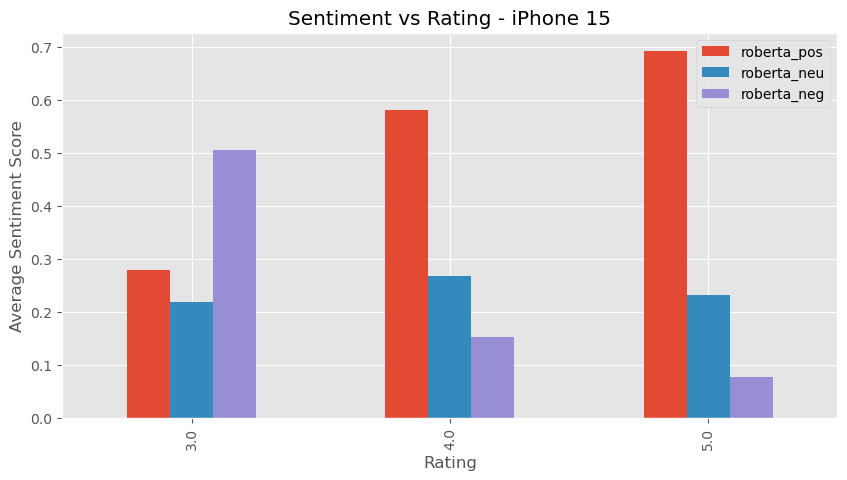

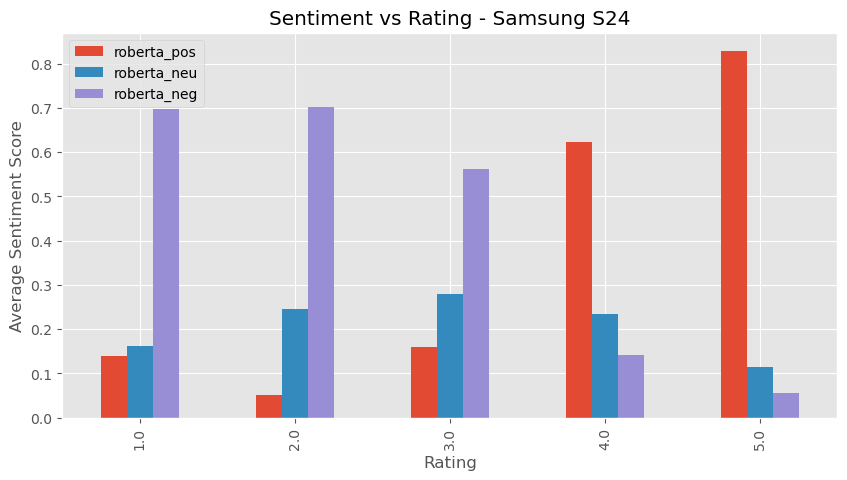

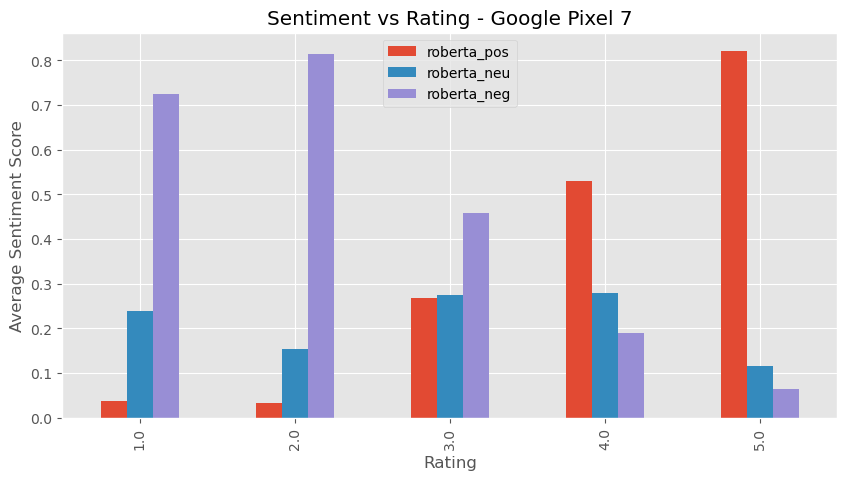

In [93]:
# Plot sentiment scores (positive, neutral, negative) vs rating for iPhone 15
sentiment_vs_rating(iphone_sentiment_df, "iPhone 15")

# Plot sentiment scores (positive, neutral, negative) vs rating for Samsung S24
sentiment_vs_rating(s24_sentiment_df, "Samsung S24")

# Plot sentiment scores (positive, neutral, negative) vs rating for Google Pixel 7
sentiment_vs_rating(pixel_sentiment_df, "Google Pixel 7")

### Sentiment vs Rating Analysis

The sentiment vs rating charts illustrate the relationship between review scores (ratings) and the RoBERTa-generated sentiment scores:

- **iPhone 15:**
As ratings increase from 3 to 5, positive sentiment sharply increases, peaking at rating 5.
Negative sentiment declines consistently with higher ratings, suggesting good alignment between review rating and sentiment content.

- **Samsung S24:**
Positive sentiment steadily rises with higher ratings.
Ratings 1 and 2 are dominated by negative sentiment, indicating that low-star reviews are driven by strong dissatisfaction.

- **Google Pixel 7:**
Low ratings (1–2) show dominant negative sentiment scores (above 0.8), highlighting serious concerns from customers.
Rating 5 sees a significant rise in positive sentiment, but lower rating clusters are predominantly negative.

This sentiment–rating alignment confirms the reliability of the sentiment classification and gives further insight into how sentiment varies with user satisfaction.

## Word Cloud for Customer Reviews

In [77]:
def plot_wordcloud(df, device_name, column='Cleaned_Review'):
    """
    Generates and displays a word cloud for the given DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the review text
    - device_name (str): Name of the device (used in the chart title)
    - column (str): Column name to pull text from (default is 'Review')
    """

    # Combine all text from the specified column into one large string
    text = " ".join(df[column].dropna().astype(str))

    # Generate a word cloud from the combined text
    wordcloud = WordCloud(
        width=1000,                # Width of the word cloud image
        height=500,                # Height of the word cloud image
        background_color='white',  # Background color of the image
        colormap='viridis',        # Color theme for the words
        max_words=200              # Limit the number of displayed words
    ).generate(text)

    # Set up the plot
    plt.figure(figsize=(15, 7))                       # Size of the output figure
    plt.imshow(wordcloud, interpolation='bilinear')   # Render the word cloud
    plt.axis('off')                                   # Hide axes for a clean look
    plt.title(f"Word Cloud of Customer Reviews - {device_name}", fontsize=16) # Set title
    plt.show()      # Display the plot


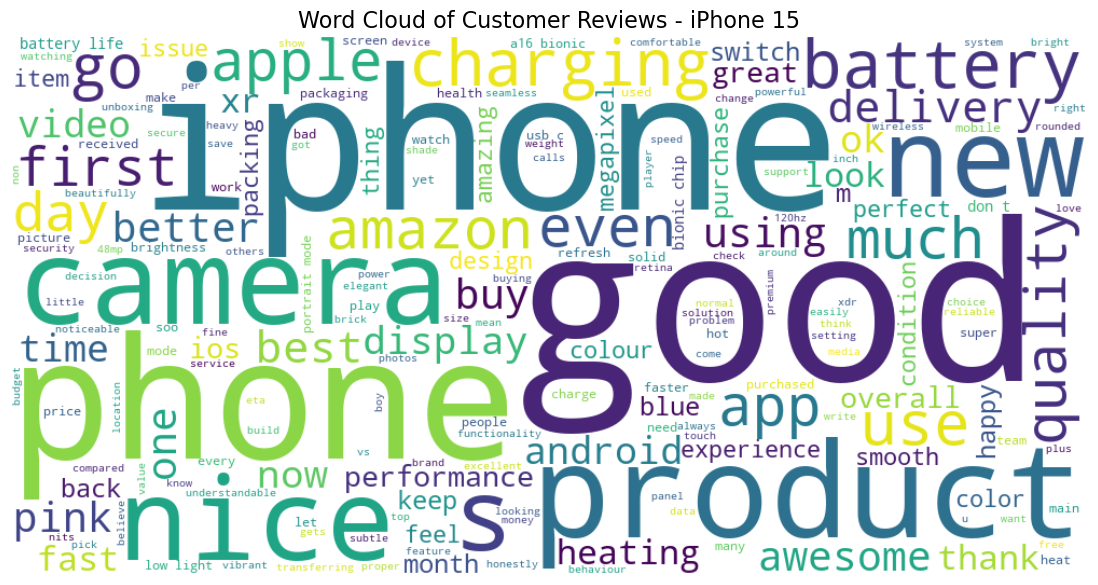

In [79]:
# Generate and display a word cloud of customer reviews for iPhone 15
# This will highlight the most frequently used words in the 'Cleaned_Review' column
plot_wordcloud(iphone_df, "iPhone 15")

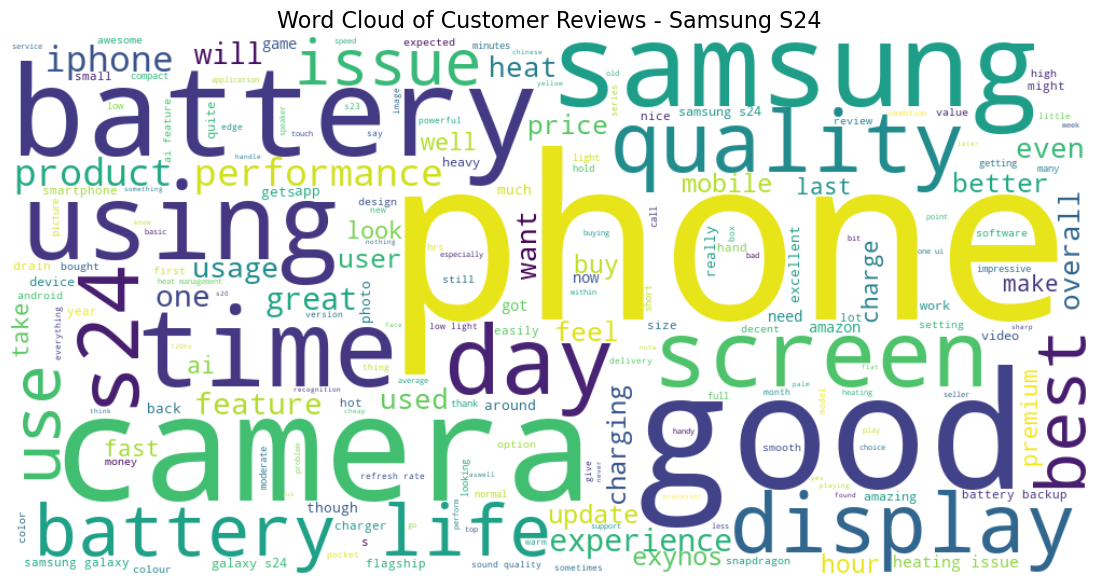

In [81]:
# Generate and display a word cloud of customer reviews for Samsung S24
# This will highlight the most frequently used words in the 'Cleaned_Review' column
plot_wordcloud(s24_df, "Samsung S24")

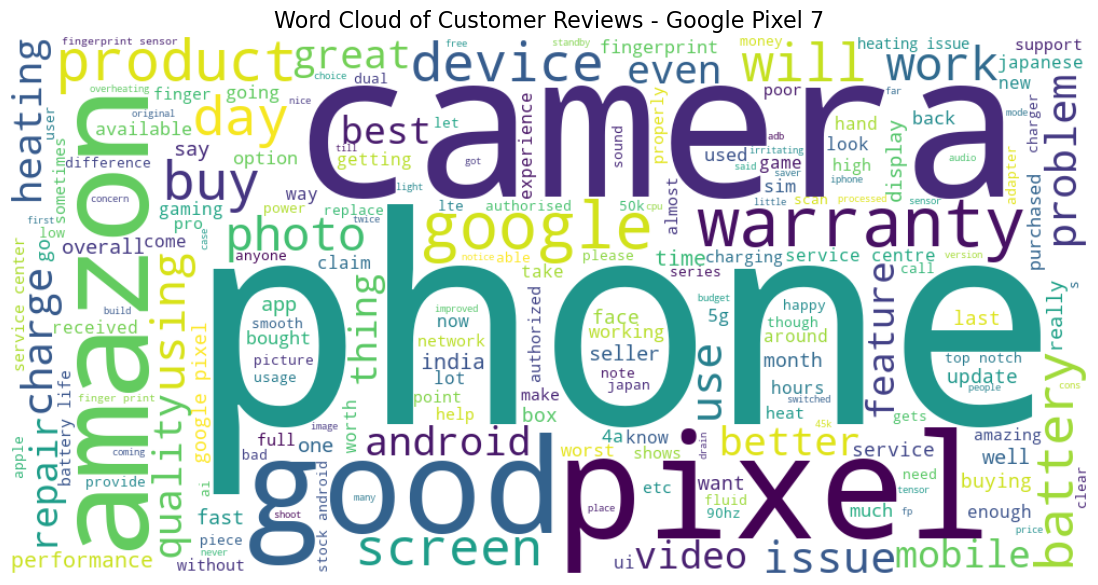

In [83]:
# Generate and display a word cloud of customer reviews for Google Pixel 7
# This will highlight the most frequently used words in the 'Cleaned_Review' column
plot_wordcloud(pixel_df, "Google Pixel 7")

## Most Frequest Complaints

In [63]:
# Filter out negative sentiment reviews from iPhone 15 dataset
iphone_neg = iphone_sentiment_df[iphone_sentiment_df['roberta_sentiment'] == 'negative']

# Filter out negative sentiment reviews from Samsung S24 dataset
s24_neg = s24_sentiment_df[s24_sentiment_df['roberta_sentiment'] == 'negative']

# Filter out negative sentiment reviews from Google Pixel 7 dataset
pixel_neg = pixel_sentiment_df[pixel_sentiment_df['roberta_sentiment'] == 'negative']


In [65]:
# Load the list of English stopwords into a set for faster lookup
stop_words = set(stopwords.words('english'))

# Function to clean and preprocess a given text string
def clean_text(text):
    text = text.lower()   # Convert text to lowercase for uniformity

    # Remove special characters and punctuation, keep only letters, numbers, and spaces
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)

    # Tokenize the cleaned text into words
    words = word_tokenize(text)

    # Remove stopwords and short words (less than 3 characters)
    words = [w for w in words if w not in stop_words and len(w) > 2]

    # Join the filtered words back into a single string
    return " ".join(words)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Netcom\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Netcom\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [1]:
# Apply text cleaning to negative reviews of iPhone 15
# Converts review text to lowercase, removes punctuation, filters stopwords, and stores in a new 'cleaned' column
iphone_neg['cleaned'] = iphone_neg['Cleaned_Review'].dropna().astype(str).apply(clean_text)

# Apply text cleaning to negative reviews of Samsung S24
s24_neg['cleaned'] = s24_neg['Cleaned_Review'].dropna().astype(str).apply(clean_text)

# Apply text cleaning to negative reviews of Google Pixel 7
pixel_neg['cleaned'] = pixel_neg['Cleaned_Review'].dropna().astype(str).apply(clean_text)


NameError: name 'iphone_neg' is not defined

In [69]:
from collections import Counter   # Import Counter to count word frequencies

def get_top_complaint_words(df, n=15):
    """
     Returns the top N most common words from the 'cleaned' column
    of a DataFrame (typically cleaned negative reviews).

    Parameters:
    - df (pd.DataFrame): DataFrame containing a 'cleaned' column with preprocessed text
    - n (int): Number of top frequent words to return (default = 15)

    Returns:
    - List of tuples: [(word, frequency), ...] for the top N words
    """

    # Combine all words in the 'cleaned' column into one string, then split into a list of words
    all_words = " ".join(df['cleaned']).split()

    # Count word frequencies and return the top N most common words
    return Counter(all_words).most_common(n)

In [71]:
# Print the most frequent complaint words from iPhone 15 negative reviews
print("📱 iPhone 15 complaints:")
print(get_top_complaint_words(iphone_neg))

# Print the most frequent complaint words from Samsung S24 negative reviews
print("\n📱 Samsung S24 complaints:")
print(get_top_complaint_words(s24_neg))

# Print the most frequent complaint words from Google Pixel7 negative reviews
print("\n📱 Google Pixel 7 complaints:")
print(get_top_complaint_words(pixel_neg))


📱 iPhone 15 complaints:
[('good', 3), ('behaviour', 2), ('heating', 2), ('condition', 2), ('packing', 2), ('volume', 2), ('product', 1), ('delivery', 1), ('boy', 1), ('blue', 1), ('dart', 1), ('company', 1), ('bad', 1), ('rude', 1), ('goodbut', 1)]

📱 Samsung S24 complaints:
[('phone', 28), ('battery', 12), ('using', 7), ('product', 7), ('samsung', 7), ('life', 7), ('quality', 6), ('minutes', 6), ('like', 6), ('feel', 5), ('camera', 5), ('heating', 5), ('snapdragon', 5), ('s24', 5), ('new', 5)]

📱 Google Pixel 7 complaints:
[('phone', 41), ('amazon', 25), ('warranty', 21), ('pixel', 18), ('service', 16), ('google', 16), ('buy', 12), ('product', 11), ('doesnt', 10), ('dont', 10), ('heating', 9), ('camera', 8), ('issue', 8), ('screen', 7), ('india', 7)]


| Device          | 🔧 Common Complaints                               | 📝 Interpretation                            |
| --------------- | -------------------------------------------------- | -------------------------------------------- |
| **iPhone 15**   | Heating, Volume, Packing, Delivery Condition       | Minor issues, no widespread negative theme   |
| **Samsung S24** | Battery Life, Heating, Camera, Build Quality       | Efficiency and thermal concerns              |
| **Pixel 7**     | Warranty, Amazon, Customer Service, Defective Unit | Major frustration with support & reliability |


### Common Customer Complaints – Comparative Summary
An analysis of the most frequent words in negative reviews revealed key complaint patterns unique to each device:

- **iPhone 15:** Complaints were minimal and less consistent, with mentions of minor issues like heating, low volume, and delivery condition. The limited repetition of negative terms suggests fewer widespread dissatisfaction themes among iPhone 15 users.

- **Samsung S24:** A strong pattern emerged around battery life, heating issues, and camera performance. Many users mentioned the phone's quick battery drain, feel, and overall product quality, indicating concerns over device efficiency and thermal performance.

- **Google Pixel 7:** Negative reviews were dominated by frustration with customer service, warranty issues, and Amazon-related problems. Keywords like "warranty," "service," "amazon," "buy," and "doesn't" suggest that many customers faced difficulties post-purchase, including defective units, poor support, and trust issues with resellers.

**This sentiment analysis highlights that:**

- iPhone 15 users mostly faced minor hardware or delivery-related concerns.

- Samsung S24 users pointed to performance-related complaints, especially battery and heating.

- Pixel 7 users reported major frustration with support and after-sales service, reflecting deeper trust and satisfaction issues.



## Sentiment Summary Table

In [95]:
def generate_sentiment_summary_table(dfs, names):
    """
    Returns a summary table comparing sentiment proportions for multiple devices.

    Parameters:
    - dfs (list): List of DataFrames (each with a 'roberta_sentiment' column)
    - names (list): List of device names corresponding to each DataFrame

    Returns:
    - pd.DataFrame: Summary table of sentiment proportions
    """
    summary_data = []  # Initialize list to store sentiment data for each device

    # Loop through each dataset and corresponding device name
    for df, name in zip(dfs, names):
        total = len(df)   # Total number of reviews for the device

        # Get proportion (%) of each sentiment class
        sentiment_counts = df['roberta_sentiment'].value_counts(normalize=True) * 100

        # Create a summary dictionary for the current device
        summary_data.append({
            'Device': name,
            'Positive (%)': round(sentiment_counts.get('positive', 0), 2),    # Round to 2 decimal places
            'Neutral (%)': round(sentiment_counts.get('neutral', 0), 2),
            'Negative (%)': round(sentiment_counts.get('negative', 0), 2)
        })

    # Convert the list of dictionaries into a summary DataFrame
    summary_df = pd.DataFrame(summary_data)

    # Return the comparison table
    return summary_df


In [97]:
# Define a list of device names to label each sentiment DataFrame
device_names = ["iPhone 15", "Samsung S24", "Google Pixel 7"]

# Generate a summary table showing sentiment proportions for each device
summary_table = generate_sentiment_summary_table(
    [iphone_sentiment_df, s24_sentiment_df, pixel_sentiment_df],   # List of sentiment-analyzed DataFrames
    device_names                                        # Corresponding device labels
)

# Display the sentiment comparison summary table
print(summary_table)


           Device  Positive (%)  Neutral (%)  Negative (%)
0       iPhone 15         72.73        20.20          7.07
1     Samsung S24         61.86        13.40         24.74
2  Google Pixel 7         36.73        13.27         50.00


Based on RoBERTa sentiment analysis of customer reviews for iPhone 15, Samsung S24, and Google Pixel 7:

iPhone 15 received the most favorable sentiment overall, with 72.73% positive reviews and the lowest negative sentiment (7.07%), indicating strong customer satisfaction and minimal dissatisfaction.

Samsung S24 also showed a majority positive sentiment (61.86%), but with a notably higher negative sentiment (24.74%), suggesting more mixed customer experiences compared to the iPhone.

Google Pixel 7 had the lowest positive sentiment (36.73%) and the highest negative sentiment (50.00%), indicating that customer feedback was predominantly unfavorable. This may point to product or expectation issues among users.

Overall, the sentiment trends suggest that iPhone 15 users are significantly more satisfied than those of Samsung S24 and Pixel 7, with Pixel 7 facing the highest level of dissatisfaction among the three devices.